# Success analysis : finding cofounders 

#### We are interested in conducting an analysis to explore the relationship between the title of a movie and its success. While the title seems to be a crucial aspect since it is a the first hook, it is undoubtable that other factors, such as the cast, director, and movie studio, may exert a more significant influence on a film's success. To gain a comprehensive understanding of the impact of the title, it is essential to analyze potential confounding variables affecting success. In this context, success is measured by both the movie revenue (box office earnings minus budget) and the ratings from IMDb.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string

In [10]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

movies = pd.read_csv('Data/movies_preprocessed.csv')

In [11]:
print('Size of the dataset : ', movies.shape)
movies.dropna(subset=['Movie_box_office_revenue'], inplace=True)
print('Size of the dataset : ', movies.shape)
movies.head()

Size of the dataset :  (26772, 11)
Size of the dataset :  (6182, 11)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False
4,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False
8,8,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['United Kingdom'],drama,"['Henry V', 'Catherine of Valois', 'Duke Thoma...",True
9,9,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['United States of America'],family,"['Jane Banks', 'George Banks', 'Bert', 'Mary P...",False
11,11,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,['United States of America'],thriller,"['Sandii', 'Fox', 'Madame Rosa']",False


In [12]:
# Load the dataframe with Consumer Price indexes (CPI)
# The year of reference is 2012 (latest movie release year)
# Adjust each movie box office with the consumer price indix corresponding to the year of release 

cpi = pd.read_csv('Data/CPI.csv', sep=';')
cpi['Annual'] = cpi['Annual'].str.replace(',', '.')
cpi['Annual'] = pd.to_numeric(cpi['Annual'], errors='coerce')

cpi_value_2012 = cpi.loc[cpi['Year'] == 2012, 'Annual'].values[0] # take 2012 as the reference year for the cpi 

def adjust_inflation_box_office(row):
    year = row['Movie_release_date']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Movie_box_office_revenue'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

# Adjust the box office with the inflation
movies['Box_office_adjusted'] = movies.apply(adjust_inflation_box_office, axis=1)
movies.head()

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Box_office_adjusted
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,1.816424e+07
4,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,5.862128e+07
8,8,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['United Kingdom'],drama,"['Henry V', 'Catherine of Valois', 'Duke Thoma...",True,1.881442e+07
9,9,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['United States of America'],family,"['Jane Banks', 'George Banks', 'Bert', 'Mary P...",False,7.574780e+08
11,11,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,['United States of America'],thriller,"['Sandii', 'Fox', 'Madame Rosa']",False,2.965919e+04


In [13]:
# Load IMDB ratings
ratings_imdb = pd.read_table('Data/ratings_imdb.tsv', sep="\t")
ratings_imdb.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688


In [19]:
# import the file with the movies titles ID from imdb
import gdown
import pandas as pd

link_drive = "https://drive.google.com/file/d/1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ/view?usp=share_link"
id_fichier = link_drive.split("/")[-2]
link_direct = f"https://drive.google.com/uc?id={id_fichier}"
name_file_local = "titles_imdb.tsv"
gdown.download(link_direct, name_file_local, quiet=False)
movie_imdb = pd.read_csv(name_file_local, sep='\t')

unuseful = ['titleType', 'isAdult', 'endYear', 'genres']
movie_imdb.drop(unuseful, axis =1, inplace=True)
movie_imdb.head()


Downloading...
From (uriginal): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ
From (redirected): https://drive.google.com/uc?id=1ZkAQhufH1q1a9aJDgs_AzR0hoo2p-LWQ&confirm=t&uuid=6da64c8b-52dc-445d-8215-b976a96358ad
To: /Users/Clarisse/Documents/ENS 1  - L3/ENS 2 - M1/ada-2023-project-randada/titles_imdb.tsv
100%|██████████| 884M/884M [01:37<00:00, 9.05MB/s] 
/var/folders/g3/cmtrqyyx2g31_0nljjqrcp800000gn/T/ipykernel_13027/1716720349.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_imdb = pd.read_csv(name_file_local, sep='\t')


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,tt0000001,Carmencita,Carmencita,1894,1
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,1892,5
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,1892,4
3,tt0000004,Un bon bock,Un bon bock,1892,12
4,tt0000005,Blacksmith Scene,Blacksmith Scene,1893,1


In [15]:
# Load budget info about movies (source : TMDb movies dataset)

budget= pd.read_csv('Data/imdb_budget.csv',sep=",")
budget['date_x']=budget['date_x'].str.strip()
budget['date_x'] = pd.to_datetime(budget['date_x'], format='%m/%d/%Y')
budget['ReleaseYear'] = budget['date_x'].dt.year
unuseful = ['overview', 'status', 'crew', 'orig_lang', 'country', 'score', 'genre', 'orig_title', 'date_x']
budget.drop(unuseful, axis =1, inplace=True)
print(budget.shape)
budget.sample(10)

(10178, 4)


,names,budget_x,revenue,ReleaseYear
8863,4x4,3000000.0,1292773.0,2020
4815,Dennis the Menace,35000000.0,117270765.0,1993
7717,Sadako DX,6030000.0,2352175.0,2022
910,Garfield,50000000.0,200804534.0,2004
7813,Never Been Kissed,25000000.0,84565230.0,1999
6103,Wither,49200000.0,427304425.6,2013
5066,Bitter Moon,5000000.0,1862805.0,1992
4699,Upon the Magic Roads,8020000.0,278663367.8,2021
4153,The Girl Who Escaped: The Kara Robinson Story,87600000.0,830669408.0,2023
1262,Be My Slave,104698000.0,531865785.2,2012


In [20]:
# Keep only movies budgets for years comrpised between 1913 ane 2012 (because of the inflation CPI dataset) 

budget = budget[(budget['ReleaseYear'] >= 1913) & (budget['ReleaseYear'] < 2013)]
budget['ReleaseYear'] = budget['ReleaseYear'].astype('int64')

# Adjust movies budgets with inflation with each consumer price index of the year of release 
def adjust_inflation_budget(row):
    year = row['ReleaseYear']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['budget_x'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

budget['budget_adjusted'] = budget.apply(adjust_inflation_budget, axis=1)
budget.head()


,names,budget_x,revenue,ReleaseYear,budget_adjusted
22,The Passion of the Christ,25000000.0,6.223136e+08,2004,3.038645e+07
58,A Bronx Tale,10000000.0,1.728790e+07,1994,1.549258e+07
61,The Forbidden Legend: Sex & Chopsticks 2,89600000.0,3.183760e+08,2009,9.590751e+07
68,Avatar,237000000.0,2.923706e+09,2009,2.536839e+08
87,Super Mario Bros.,42000000.0,2.084491e+07,1993,6.673495e+07


In [21]:
#load the dataset with the list of famous actors (top 100 from IMdB) and filter the useful columns 

famous_actors= pd.read_csv('Data/famous_actors.csv')
famous_actors.head()
unuseful = ['Description', 'Birth Date', 'Created', 'Modified', 'Known For', 'Position']
famous_actors.drop(unuseful, axis =1, inplace=True)
famous_actors.head()


,Const,Name
0,nm0000134,Robert De Niro
1,nm0000197,Jack Nicholson
2,nm0000008,Marlon Brando
3,nm0000243,Denzel Washington
4,nm0000031,Katharine Hepburn


In [22]:
#clean the movie dataset from imdb

movie_imdb['startYear'] = movie_imdb['startYear'].replace('\\N', np.nan)
movie_imdb['runtimeMinutes'] = movie_imdb['runtimeMinutes'].replace('\\N', np.nan)

movie_imdb.dropna(subset=['startYear'], inplace =True)
movie_imdb.dropna(subset=['runtimeMinutes'], inplace =True)

movie_imdb['startYear']=movie_imdb['startYear'].astype('int')
movie_imdb['runtimeMinutes']=movie_imdb['runtimeMinutes'].astype(int).astype('int')

In [23]:
# merging imdb movies dataset and CMU movies dataset on Movie title, release date and runtime 

merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")
print('Size of the new dataset : ', merged_movies.shape)
merged_movies.head()

/var/folders/g3/cmtrqyyx2g31_0nljjqrcp800000gn/T/ipykernel_13027/1580238346.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_movies = movies.merge(movie_imdb,left_on=['Movie_name', 'Movie_release_date', 'Movie_runtime'],right_on=['primaryTitle', 'startYear', 'runtimeMinutes'], how="inner")


Size of the new dataset :  (3151, 17)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Box_office_adjusted,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,1.816424e+07,tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98
1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,5.862128e+07,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106
2,8,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['United Kingdom'],drama,"['Henry V', 'Catherine of Valois', 'Duke Thoma...",True,1.881442e+07,tt0097499,Henry V,Henry V,1989,137
3,9,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['United States of America'],family,"['Jane Banks', 'George Banks', 'Bert', 'Mary P...",False,7.574780e+08,tt0058331,Mary Poppins,Mary Poppins,1964,139
4,14,1364293,/m/04wy0v,They Knew What They Wanted,1940,932000.0,96.0,['United States of America'],romance,['Amy Peters'],False,1.528480e+07,tt0033150,They Knew What They Wanted,They Knew What They Wanted,1940,96


In [24]:
#adding the ratings feature, merging on tconst

movies_with_ratings= merged_movies.merge(ratings_imdb, left_on='tconst', right_on='tconst', how='inner')
print('Size of the dataset with the ratings : ', movies_with_ratings.shape)
movies_with_ratings.head()

Size of the dataset with the ratings :  (3149, 19)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Box_office_adjusted,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,1.816424e+07,tt0228333,Ghosts of Mars,Ghosts of Mars,2001,98,4.9,56894
1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,5.862128e+07,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,6.8,2268
2,8,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,['United Kingdom'],drama,"['Henry V', 'Catherine of Valois', 'Duke Thoma...",True,1.881442e+07,tt0097499,Henry V,Henry V,1989,137,7.5,31193
3,9,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,['United States of America'],family,"['Jane Banks', 'George Banks', 'Bert', 'Mary P...",False,7.574780e+08,tt0058331,Mary Poppins,Mary Poppins,1964,139,7.8,181710
4,14,1364293,/m/04wy0v,They Knew What They Wanted,1940,932000.0,96.0,['United States of America'],romance,['Amy Peters'],False,1.528480e+07,tt0033150,They Knew What They Wanted,They Knew What They Wanted,1940,96,6.1,479


In [25]:
# Merging the budget dataset with the preprocessed movies dataset on the movie name and the year of release 

movies_budget_ratings = movies_with_ratings.merge(budget, left_on=['Movie_name', 'Movie_release_date'], right_on=['names', 'ReleaseYear'], how='inner')
print('Size of the dataset with the budget : ', movies_budget_ratings.shape)

# Adding the profit column, with Profit = Box office - Budget 

#movies['budget'] = movies['budget'].astype(float)
#movies['revenue'] = movies['revenue'].astype(float)
movies_budget_ratings['profit'] = movies_budget_ratings['Box_office_adjusted'] - movies_budget_ratings['budget_adjusted']


Size of the dataset with the budget :  (859, 24)


In [26]:
# Normalise the profits and the ratings to have homogenised and comparatible success indicators

success_data= movies_budget_ratings.copy(deep= True)
success_data['Movie_box_office_revenue'].dropna(inplace = True)
print('Size of the dataset with the budget and ratings : ', success_data.shape)

success_data['profit_normalised']= ((success_data['profit']-success_data['profit'].mean())/ success_data['profit'].std())
success_data['averageRating_normalised']= (success_data['averageRating']-success_data['averageRating'].mean())/ success_data['averageRating'].std()


# Create an indicator for success, based on ratings and box office revenues
success_data["success"]= (success_data['averageRating'] + success_data['profit'])/2
success_data.sample(10)




Size of the dataset with the budget and ratings :  (859, 25)


,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,...,numVotes,names,budget_x,revenue,ReleaseYear,budget_adjusted,profit,profit_normalised,averageRating_normalised,success
93,3476,18305011,/m/03yfkw5,Wonder Woman,2009,6898033.0,74.0,['United States of America'],action,"['Steve Trevor', 'Hera', 'Wonder Woman', 'Arte...",...,18528,Wonder Woman,150000000.0,817691766.0,2009,1.605594e+08,-1.531758e+08,-1.001819,0.866191,-7.658790e+07
38,1633,1898116,/m/064ndc,Radio,2003,53293628.0,109.0,['United States of America'],sport,"['Linda', 'Radio', 'Coach Jones', 'Principal D...",...,43132,Radio,35000000.0,53293628.0,2003,4.367391e+07,2.282727e+07,-0.272315,0.547445,1.141364e+07
496,16193,5533243,/m/0dr89x,The Bridges of Madison County,1995,182016617.0,135.0,['United States of America'],romance,"['Lucy Redfield', 'Robert Kincaid', 'Francesca...",...,86815,The Bridges of Madison County,22000000.0,175516617.0,1995,3.314436e+07,2.410749e+08,0.632285,1.291184,1.205375e+08
702,22589,612018,/m/02wgbb,The Flintstones in Viva Rock Vegas,2000,59468275.0,90.0,['United States of America'],family,"['Fred Flintstone', 'Barney Rubble', 'Wilma Fl...",...,24974,The Flintstones in Viva Rock Vegas,58000000.0,59431365.0,2000,7.733333e+07,1.957700e+06,-0.358816,-2.852504,9.788518e+05
518,16808,145663,/m/012jfb,Bowling for Columbine,2002,58008423.0,120.0,"['United States of America', 'Canada', 'Germany']",political,NaN,...,147578,Bowling for Columbine,3000000.0,58240487.0,2002,3.828794e+06,7.020530e+07,-0.075941,1.716178,3.510266e+07
161,5669,689763,/m/032_76,Species,1995,113374103.0,108.0,['United States of America'],fiction,"['Dan Smithson, Empath', 'Dr. Laura Baker', 'Y...",...,83821,Species,35000000.0,113354449.0,1995,5.272966e+07,1.180754e+08,0.122472,-0.515039,5.903771e+07
242,7772,948548,/m/03sjgd,Clash of the Titans,1981,41000000.0,118.0,['United States of America'],adventure,"['Hera', 'Thetis', 'Aphrodite', 'Poseidon', 'A...",...,46822,Clash of the Titans,125000000.0,493214888.0,1981,3.157316e+08,-2.121716e+08,-1.246347,0.547445,-1.060858e+08
363,11529,14478278,/m/03m3xm8,Planet 51,2009,105432013.0,91.0,"['United States of America', 'Spain', 'United ...",fiction,"['Professor Kipple', 'Captain Charles T. Baker...",...,57720,Planet 51,60000000.0,108996113.0,2009,6.422378e+07,4.863026e+07,-0.165366,-0.408791,2.431513e+07
393,12519,3030582,/m/08lr6s,The Scarlet Letter,1995,10382407.0,135.0,['United States of America'],drama,"['Roger Chillingworth', 'Hester Prynne', 'Arth...",...,16056,The Scarlet Letter,50000000.0,10359006.0,1995,7.532808e+07,-5.968635e+07,-0.614321,-1.152529,-2.984317e+07
616,19968,19992131,/m/02pxhgv,After.Life,2009,3260454.0,104.0,['United States of America'],thriller,"['Eliot Deacon', 'Anna Taylor', 'Paul Coleman'...",...,40450,After.Life,4500000.0,2481925.0,2009,4.816783e+06,-1.326805e+06,-0.372430,-0.515039,-6.633998e+05


In [29]:
# Do famous actors influence the movie rating ?

# Merge movies and character metadata to have access to actors information for each movie, on Wipikedia_movie_ID
movies_and_actors = success_data.merge(character_metadata, on='Wikipedia_movie_ID', how='inner')

# To be considered as famous, an actor has to be in the famous_actors dataset
movies_and_actors['IsFamousActor']=movies_and_actors['Actor_name'].isin(famous_actors['Name'])

# Group movies and actors dataframe by movie and aggregate actors and characters
grouped_movies_actors = movies_and_actors.groupby('Wikipedia_movie_ID').agg({
      'Freebase_movie_ID_x': 'first', 'Movie_name': 'first',
       'Movie_release_date_x': 'first', 'Movie_box_office_revenue': 'first', 'Movie_runtime': 'first',
        'Movie_countries': 'first', 
       'averageRating': 'first', 'budget_x': 'first', 
       'profit': 'first', 'success': 'first', 
       'Freebase_actor_ID': 'first', 'IsFamousActor': 'first',
    'Actor_name': lambda x: ', '.join(x.dropna()),
    #'Character_name': lambda x: ', '.join(x.dropna()),
    'Freebase_character_ID': lambda x: ', '.join(x.dropna())
}).reset_index()
print('Size of the dataset with the actors: ', grouped_movies_actors.shape)

grouped_movies_actors.head()


Size of the dataset with the actors:  (824, 15)


,Wikipedia_movie_ID,Freebase_movie_ID_x,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_countries,averageRating,budget_x,profit,success,Freebase_actor_ID,IsFamousActor,Actor_name,Freebase_character_ID
0,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],5.7,7000000.0,1.575036e+07,7.875181e+06,/m/0337zp,False,"Kristy Swanson, Donald Sutherland, Paul Reuben...","/m/0b41h, /m/0h5s5mz, /m/0h5s5p6, /m/0h2n0pr, ..."
1,4728,/m/01hq1,Batman Returns,1992,266822354.0,126.0,"['United States of America', 'United Kingdom']",7.1,80000000.0,3.057335e+08,1.528668e+08,/m/0c4f8m,False,"Cristi Conaway, Michael Gough, Pat Hingle, Jan...","/m/0h5rr59, /m/02r129, /m/031v20, /m/0h5rr4q, ..."
2,9835,/m/02p5d,Escape from New York,1981,50000000.0,99.0,"['United States of America', 'United Kingdom']",7.1,6000000.0,1.111375e+08,5.556876e+07,/m/09r5rb,False,"Frank Doubleday, Kurt Russell, Lee Van Cleef, ...","/m/0h5twsj, /m/0345b_, /m/0h2y3nn, /m/0h5twr6,..."
3,9979,/m/02qcr,Eyes Wide Shut,1999,162091208.0,159.0,"['United States of America', 'United Kingdom']",7.5,65000000.0,1.338064e+08,6.690319e+07,/m/0gbzrrl,False,"Mariana Hewett, Tom Cruise, Nicole Kidman, Mad...","/m/0h5pb_4, /m/04jt3h_, /m/04dsqgh, /m/0g9f7s0..."
4,10487,/m/02vhv,Evil Dead II,1987,10900000.0,84.0,['United States of America'],7.7,3500000.0,1.495634e+07,7.478173e+06,/m/0gby7_x,False,"Richard Domeier, Bruce Campbell, Ted Raimi, Da...","/m/0h608bf, /m/06_krl, /m/0h608c0, /m/0h608b6,..."


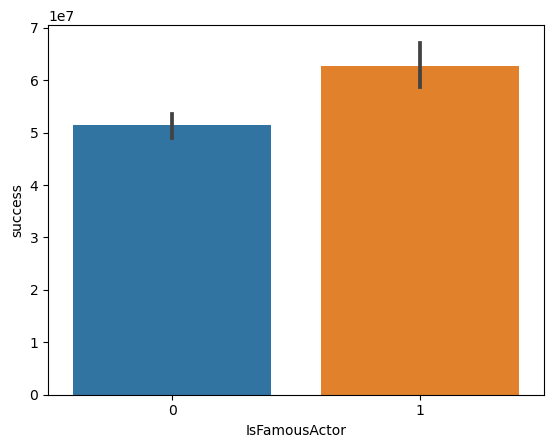

In [30]:
# We are examining the impact of the cast on the success of a movie, aiming to determine whether the presence of renowned actors (IsFamousActor=1) contributes to greater success in a film.

movies_and_actors['IsFamousActor'] = movies_and_actors['IsFamousActor'].astype(int)
ax = sns.barplot(data=movies_and_actors, x=movies_and_actors['IsFamousActor'],y=movies_and_actors['success'])

#est-ce qu'on garde que les films avec un revenue pour l'analyse du succès ? ça réduit beaucoup le dataframe non ? et est-ce qu'on ajuste avec l'inflation ?